In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN, OPTICS, KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
#from module import *
%matplotlib inline
def raman_plot():
    """
    Funzione che serve per settare la dimensione dell'immgine e i label degli assi per un plot di spettro Raman.
    """
    plt.figure(figsize=(16,6))
    plt.xlabel("wave number [1/cm]")
    plt.ylabel("Intensity")

# Import dei dati

In [54]:
# import dei centroidi
data = pd.read_csv("../data/processed/CLUSTERING_data_centres.csv")
data.drop(labels='Unnamed: 0',inplace=True,axis=1)
data.head()

,wn,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,184.0,-0.000100,-0.000228,-0.000177,-0.000039,-0.000022,0.000507,-0.000110,-0.000507,0.000240,-0.000344,0.000150,1.721492e-04,-0.000722,-0.000230,-0.000204
1,185.0,-0.000055,-0.000169,-0.000216,0.000040,-0.000007,0.000671,-0.000112,-0.000359,0.000084,-0.000282,0.000154,9.756678e-05,-0.000772,-0.000257,-0.000253
2,186.0,-0.000061,-0.000159,-0.000233,0.000039,-0.000012,0.000725,-0.000118,-0.000349,0.000030,-0.000275,0.000135,5.995975e-05,-0.000794,-0.000273,-0.000275
3,187.0,-0.000075,-0.000148,-0.000247,0.000005,-0.000024,0.000790,-0.000113,-0.000355,-0.000052,-0.000292,0.000100,2.595913e-07,-0.000816,-0.000273,-0.000296
4,188.0,-0.000110,-0.000141,-0.000251,-0.000103,-0.000050,0.000860,-0.000085,-0.000412,-0.000182,-0.000371,0.000030,-9.934144e-05,-0.000837,-0.000235,-0.000314


In [3]:
# import degli spettri puri
# definisco i nomi dei vari materiali usando il file che li contiene tutti
pure_material_names=[]
with open('../data/raw/Database Raman/BANK_LIST.dat') as f:
    pure_material_names=[i[1:len(i)-5] for i in f.readlines()]
l=[]
# calcolo la dimensione del materiale puro con più dati
for i in range(len(pure_material_names)):
    l.append(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wl',pure_material_names[i]+'_I']).size)
max_size=int(max(l)/2)
# genero un dataframe vuoto per poter usare il metodo join
pure_materials = pd.DataFrame(np.zeros(max_size),columns=['empty'])
# importiamo i dati: nome_I (intensità) e nome_wn
for i in range(len(pure_material_names)):
    pure_materials=pure_materials.join(pd.read_csv('../data/raw/Database Raman/'+pure_material_names[i]+'.txt', delim_whitespace=True, names=[pure_material_names[i]+'_wn',pure_material_names[i]+'_I']))
    
pure_materials.drop('empty', axis = 1,inplace=True)

# Interpolazione

Ora devo interpolare gli spettri puri ai dati

In [4]:
pure_materials_interpoled=pd.DataFrame(data.wn.copy())
for temp in pure_material_names:
    pure_materials_interpoled=pure_materials_interpoled.join(pd.DataFrame(np.interp(data.wn, pure_materials[temp+'_wn'] ,pure_materials[temp+'_I']),columns=[temp]))


In [5]:
#Normalizzazione
for i in pure_material_names:
    pure_materials_interpoled[i]=pure_materials_interpoled[i]/np.trapz(abs(pure_materials_interpoled[i].dropna()), x=pure_materials_interpoled[i])

# Fit

In [55]:
ols = LinearRegression(positive=True) #definisco il regressore

In [79]:
N_cluster=len(data.columns)-1
coeff=[]
for i in range(N_cluster):
    ols.fit(pure_materials_interpoled[pure_material_names], data[str(i)])#ottimizziamo il modello (lineare) su i dati di training
    coeff.append(ols.coef_)
    

In [63]:
ols.fit(pure_materials_interpoled[pure_material_names], data['1'])#ottimizziamo il modello (lineare) su i dati di training

LinearRegression(positive=True)

In [64]:
np.where(ols.coef_==ols.coef_.max()) #i miei w, vediamo che, come si vedeva dal grafico
pure_material_names[41]

'Monticellite'

In [65]:
a=np.sum(pure_materials_interpoled[pure_material_names]*ols.coef_,axis=1)
ols.coef_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.04908131e-06, 0.00000000e+00, 0.00000000e+00,
       1.78994905e-03, 2.64867083e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       3.57805763e-04, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.85645880e-07, 1.18644085e-05,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 6.86064264e-05, 9.38393266e-05,
       0.00000000e+00, 0.00000000e+00, 7.94603940e+00, 5.24725777e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.73334040e-06, 6.75817248e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

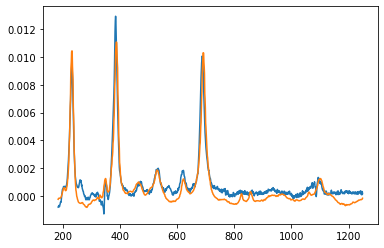

In [49]:
plt.plot(data.wn,a)
plt.plot(data.wn,data['1'])